# Tarea de Clasificación Multiclase
## - Clasificación de Cardiopatías en base a Electrocardiogramas (ECGs)

Este conjunto de datos se compone de dos colecciones de señales de latido derivadas de dos conjuntos de datos famosos en la clasificación de latidos, el conjunto de datos de arritmias [KAGGLE](https://www.kaggle.com/shayanfazeli/heartbeat). La cantidad de muestras en ambas colecciones es lo suficientemente grande para entrenar una red neuronal profunda.

Este conjunto de datos se ha utilizado para explorar la clasificación de latidos utilizando arquitecturas de redes neuronales profundas y observar algunas de las capacidades de transferencia de aprendizaje en él.

Las señales corresponden a formas de latidos cardíacos de electrocardiograma (ECG) para el caso normal y los casos afectados por diferentes arritmias e infarto de miocardio. Estas señales se preprocesan y segmentan, y cada segmento corresponde a un latido.

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Training verbosity
VERBOSE = 1

# Google Colab
COLAB = True

# TB callbacks
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TBLOGDIRS = {'mitbih': 'logs/mitbih/tb_'}
TBLOGDIRS = {k:v+current_time for (k,v) in TBLOGDIRS.items()}
tensorboard = TensorBoard(TBLOGDIRS['mitbih'], histogram_freq = 1)

## Carga de datos

In [ ]:
data_train = pd.read_csv('mitbih_train.csv')
data_test = pd.read_csv('mitbih_test.csv')

In [ ]:
#data_train = pd.read_parquet('mitbih_train.parquet')
#data_test = pd.read_parquet('mitbih_test.parquet')

In [ ]:
#data_train.head()

In [ ]:
#data_test.tail()

In [ ]:
X_train = data_train.iloc[:,:187]
X_test = data_test.iloc[:, :187]

In [ ]:
Y_train = data_train.iloc[:,187]
Y_test = data_test.iloc[:,187]

In [ ]:
classes = np.unique(Y_train)
nclasses = len(classes)

In [ ]:
list(classes)

[0.0, 1.0, 2.0, 3.0, 4.0]

## Pequeño analisis exploratorio de la distribución de las clases

(array([0.82772721, 0.02539033, 0.06610853, 0.00732128, 0.07345265]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

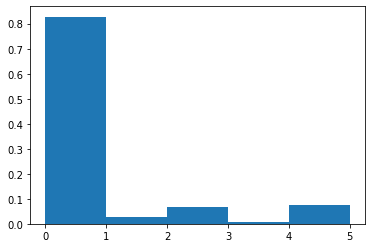

In [ ]:
plt.hist(Y_train, bins=np.arange(Y_train.min(), Y_train.max()+2), density = True)

In [ ]:
print(Y_train.value_counts())

0.0    72470
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 0.000000000000000000e+00.88, dtype: int64


## One-Hot Encoding con Keras

In [ ]:
Y_train = keras.utils.to_categorical(Y_train, nclasses)
Y_test = keras.utils.to_categorical(Y_test, nclasses)

In [ ]:
Y_train[:2]

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
Y_train.shape

(87553, 5)

In [ ]:
Y_test.shape

(21891, 5)

## Partición de Train dataset en Train (SubTrain) y Validation datasets

In [ ]:
X_train, X_val, Y_train , Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 1)

## Construcción de red neuronal con arquitectura feedforward sencilla (2 capas)

In [ ]:
input_dim = X_train.shape[1]

In [ ]:
input_dim

187

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape = (input_dim,), activation='relu'))
model.add(Dense(nclasses, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                12032     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 12,357
Trainable params: 12,357
Non-trainable params: 0
_________________________________________________________________


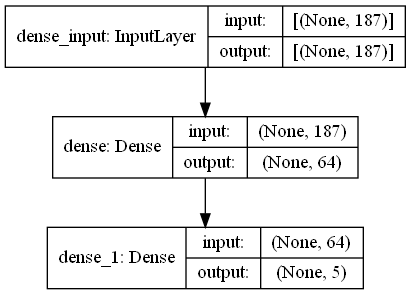

In [ ]:
keras.utils.plot_model(model, show_shapes= True)

## Definición de:
- ### Hiperparametros de entrenamiento (Learning Rate, Loss Function, Optimizer, Batch Size, Epochs)
- ### Métrica objetivo (accuracy?)

In [ ]:
learn_rate = .001
opt = Adam(learning_rate= learn_rate)

In [ ]:
model.compile(optimizer= opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
batch_size = 10
epochs = 3

## Entrenamiento

In [ ]:
training_history = model.fit(X_train,Y_train,
                            validation_data = (X_val,Y_val),
                            batch_size = batch_size,
                            epochs = epochs,
                            callbacks = TensorBoard(TBLOGDIRS['mitbih'], histogram_freq=1),
                            verbose = VERBOSE)

Epoch 1/3
7005/7005 [==============================] - 10s 1ms/step - loss: 0.2662 - accuracy: 0.9259 - val_loss: 0.1866 - val_accuracy: 0.9497
Epoch 2/3
7005/7005 [==============================] - 9s 1ms/step - loss: 0.1727 - accuracy: 0.9528 - val_loss: 0.1597 - val_accuracy: 0.9569
Epoch 3/3
7005/7005 [==============================] - 8s 1ms/step - loss: 0.1451 - accuracy: 0.9599 - val_loss: 0.1395 - val_accuracy: 0.9633


In [ ]:
y_pseudo_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pseudo_probabilities, axis = 1)
y_test = np.argmax(Y_test, axis = 1)

## Evaluacion del modelo

In [ ]:
from utils import eval_model

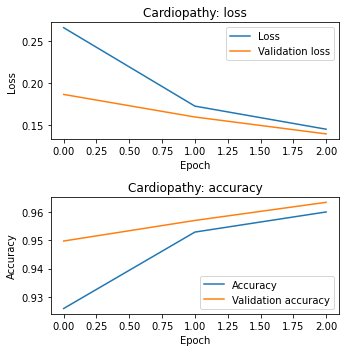

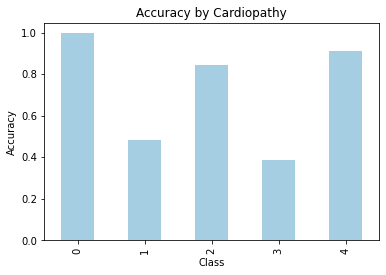

Classification report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18117
           1       0.94      0.48      0.64       556
           2       0.93      0.84      0.88      1448
           3       0.81      0.39      0.53       162
           4       0.99      0.91      0.95      1608

    accuracy                           0.96     21891
   macro avg       0.93      0.72      0.79     21891
weighted avg       0.96      0.96      0.96     21891

Confusion matrix
[[18047    17    41     1    11]
 [  265   268    23     0     0]
 [  207     0  1220    14     7]
 [   80     0    19    63     0]
 [  128     0    14     0  1466]]


Loss function: 0.14181195199489594, accuracy: 0.9622219204902649


In [ ]:
 eval_model(training_history, model, X_test, Y_test, 'Cardiopathy')

# Tarea

### Ejercicio 1. Implemente y evalue una red de 3 capas utilizando la técnica de regularización dropout

In [ ]:
# SU CÓDIGO AQUI

### Ejercicio 2. Implemente y evalue una red de 6 capas utilizando la técnica de regularización Early Stopping de 1 Fase

In [ ]:
# SU CÓDIGO AQUI

### Ejercicio 3. Pongase creativo e implemente y evalue una red neuronal a gusto, que utilice al menos 2 técnicas vistas en el teórico

In [ ]:
# SU CÓDIGO AQUI

### Ejercicio 4. Desarrolle en lenguaje natural, un texto describiendo las arquitecturas utilizadas, cual considera que dio mejor resultado y porque.

#### Su texto aqui